In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Example - System identification with expectation maximization

We will now move on from the filtering and smoothing problems to the problem of system identification. Previously, we were trying to estimate the state of a system given some noisy observations. Now, we will try to estimate the parameters of a system given some noisy observations, this is the system identification problem.

We will be doing this with the expectation maximization algorithm. The expectation maximization algorithm is a general algorithm for maximum likelihood estimation when there are latent variables involved. As a reminder of the process, the algorithm is as follows:

+ Inintialize the parameters $\theta^{(0)}$

+ E-step: Construct the function

$$
Q(\theta| \theta^{(k)}) = \mathbb{E}_{p_{\theta^{(k)}}(x_{1:T}|y_{1:T})}[\log p_{\theta}(y_{1:T}, x_{1:T})]
$$

+ M-step: Solve the optimization problem

$$
\theta^{(k+1)} = \arg \max_{\theta} Q(\theta| \theta^{(k)})
$$

+ Iterate until convergence

In [51]:
!pip install diffrax optax blackjax seaborn toml git+https://github.com/PredictiveScienceLab/dax.git

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/PredictiveScienceLab/dax.git to /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-3dmzjay4
  Running command git clone --filter=blob:none --quiet https://github.com/PredictiveScienceLab/dax.git /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-3dmzjay4
  Resolved https://github.com/PredictiveScienceLab/dax.git to commit 022ce93c3ce7929adcbb750ef70d5058b34e8a4b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [52]:
import time
import dax
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import optax

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(42)

### Duffing Oscillator

Let's revisit the Duffing Oscillator example.

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t) + \sigma \xi(t)$$

The parameters of the system that we will be trying to find are $\theta = [ \alpha, \beta, \delta, \sigma]$.

We will do the usual steps to get the state space representation as we did in the filtering and smoothing notebooks.

In [53]:
# Define the right-hand side, deterministic part of the Duffing oscillator
class DuffingControl(dax.ControlFunction):

    omega: jax.Array

    def __init__(self, omega):
        self.omega = jnp.array(omega)
    
    def _eval(self, t):
        # This is to avoid training the parameter
        omega = jax.lax.stop_gradient(self.omega)
        return jnp.cos(omega * t)

    
class Duffing(dax.StochasticDifferentialEquation):

    alpha: jax.Array
    beta: jax.Array
    delta: jax.Array

    gamma: jax.Array
    log_sigma_x: jax.Array
    log_sigma_v: jax.Array

    @property
    def sigma_x(self):
        return jnp.exp(self.log_sigma_x)

    @property
    def sigma_v(self):
        return jnp.exp(self.log_sigma_v)

    def __init__(self, alpha, beta, gamma, delta, sigma_x, sigma_v, u):
        super().__init__(control_function=u)
        self.alpha = jnp.array(alpha)
        self.beta = jnp.array(beta)
        self.delta = jnp.array(delta)

        self.gamma = jnp.array(gamma)
        self.log_sigma_x = jnp.log(sigma_x)
        self.log_sigma_v = jnp.log(sigma_v)
    
    def drift(self, x, u):
        # We won't train gamma
        gamma = jax.lax.stop_gradient(self.gamma)
        return jnp.array([x[1], -self.delta * x[1] - self.alpha * x[0] - self.beta * x[0] ** 3 + gamma * u])
    
    def diffusion(self, x, u):
        # We won't train sigma_x and sigma_v
        sigma_x = jax.lax.stop_gradient(self.sigma_x)
        sigma_v = jax.lax.stop_gradient(self.sigma_v)
        return jnp.array([sigma_x, sigma_v])

We will first define the true system parameters and generate our noisy data.

In [54]:
omega = 1.2
alpha = -1.0
beta = 1.0
delta = 0.3
gamma = 0.5
sigma_x = 0.01
sigma_v = 0.05
u = DuffingControl(omega)
true_sde = Duffing(alpha, beta, gamma, delta, sigma_x, sigma_v, u)

# True initial conditions
true_x0 = jnp.array([1.0, 0.0])

# Observation model
observation_function = dax.SingleStateSelector(0)
# Observation variance
s = 0.1
true_likelihood = dax.GaussianLikelihood(s, observation_function)

# Generate synthetic data
t0 = 0.0
t1 = 40.0
dt = 0.1
key = jr.PRNGKey(0)
sol = true_sde.sample_path(key, t0, t1, true_x0, dt=dt, dt0=0.05)
key, subkey = jr.split(key)
xs = sol.ys
ts = sol.ts
us = u(ts)
keys = jr.split(key, xs.shape[0])
ys = true_likelihood.sample(xs, us, keys)

# Training data
t_train = 200
ts_train = ts[:t_train]
ts_train_w_init = jnp.concatenate([jnp.array([ts[0] - dt]), ts_train])
ys_train = ys[:t_train]
us_train = us[:t_train]

# Test data
ts_test = ts[t_train-1:-1]
us_test = us[t_train:]

Now we will define the initial parameters of the system $\theta^{(0)}$. Experiment with far away can we start from the true parameters and still get a good estiamte.

In [55]:
# Start a model from the wrong parameters
alpha_0 = 0.0
beta_0 = 0.0
delta_0 = 0.0
sigma_0 = 2.0

sde = Duffing(alpha_0, beta_0, gamma, delta_0, sigma_x, sigma_v, u)

Build a Gaussian likelihood function for the estimation of the parameters, the E-step.

In [56]:
class GaussianLikelihood(dax.Likelihood):

    s: jax.Array

    def __init__(self, s):
        self.s = jnp.array(s)

    def _log_prob(self, y, x, u):
        return -0.5 * jnp.sum( ((y - x[0]) / self.s) ** 2) - jnp.log(self.s)
    
    def _sample(self, x, u, key):
        return x[0] + self.s * jr.normal(key, shape=x.shape)

Construct the state space representation of the system with these parameters.

In [57]:
# Define the state space model
ssm = dax.StateSpaceModel(
    dax.DiagonalGaussian(
        jnp.array([0.0, 1.0]),
        jnp.array([2.0, 2.0])),
    dax.EulerMaruyama(sde, dt=dt),
    GaussianLikelihood(sigma_0)
)

Since we are only guaranteed to find a local maximum, you may need to play around with the algorithm hyperparameters to get a good estimate of the true parameters.

In [58]:
# EM hyperparameters
num_particles = 1_000
m_step_iters = 100
em_iters = 100
learning_rate = 1e-3

# Initialize the filter, smoother, and optimizer
filter = dax.BootstrapFilter(num_particles=num_particles)
smoother = dax.BootstrapSmoother(1)
optimizer = optax.adam(learning_rate)

# Run EM
em = dax.ExpectationMaximization(filter, smoother, optimizer, max_m_step_iters=m_step_iters)
ssm, log_L = em.run(ssm, us_train, ys_train, em_iters, key)

log likelihood: -1.89e+02
log likelihood: -1.64e+02
log likelihood: -1.45e+02
log likelihood: -1.29e+02
log likelihood: -1.16e+02
log likelihood: -1.05e+02
log likelihood: -9.57e+01
log likelihood: -8.47e+01
log likelihood: -7.60e+01
log likelihood: -6.48e+01
log likelihood: -5.07e+01
log likelihood: -4.01e+01
log likelihood: -3.23e+01
log likelihood: -3.26e+01
log likelihood: -2.26e+01
log likelihood: -2.03e+01
log likelihood: -1.13e+01
log likelihood: -1.67e+01
log likelihood: -1.62e+01
log likelihood: -5.73e+00
log likelihood: -1.06e+01
log likelihood: 8.06e+00
log likelihood: 2.03e+01
log likelihood: 2.72e+01
log likelihood: 2.74e+01
log likelihood: 4.25e+01
log likelihood: 6.72e+01
log likelihood: 8.62e+01
log likelihood: 1.04e+02
log likelihood: 1.27e+02
log likelihood: 1.40e+02
log likelihood: 1.57e+02
log likelihood: 1.85e+02
log likelihood: 2.09e+02
log likelihood: 2.34e+02
log likelihood: 2.36e+02
log likelihood: 2.48e+02
log likelihood: 2.54e+02
log likelihood: 2.54e+02
log 

Let's take a look at our likelihood evolution to check for convergence.

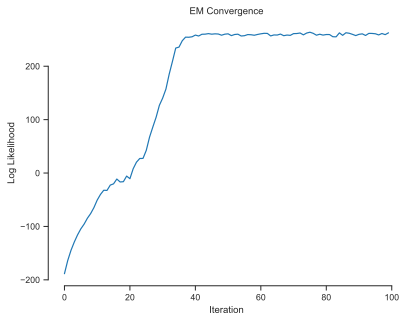

In [59]:
fig, ax = plt.subplots()
ax.plot(log_L)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Likelihood')
ax.set_title('EM Convergence')
sns.despine(trim=True)
plt.show()

Let's compare our estimated parameters to the true parameters.

In [60]:
print(f'True alpha = {alpha}, Estimated alpha: {ssm.transition.sde.alpha:.2f}')
print(f'True beta = {beta}, Estimated beta: {ssm.transition.sde.beta:.2f}')
print(f'True delta = {delta}, Estimated delta: {ssm.transition.sde.delta:.2f}')
print(f'True sigma = {sigma_x}, Estimated sigma: {ssm.likelihood.s:.2f}')

True alpha = -1.0, Estimated alpha: -0.91
True beta = 1.0, Estimated beta: 0.93
True delta = 0.3, Estimated delta: 0.38
True sigma = 0.01, Estimated sigma: 0.15


That is pretty good. Can you adjust the EM hyperparameters to get a better estimate?

Let's use our estimated parameters to predict the state of the system.

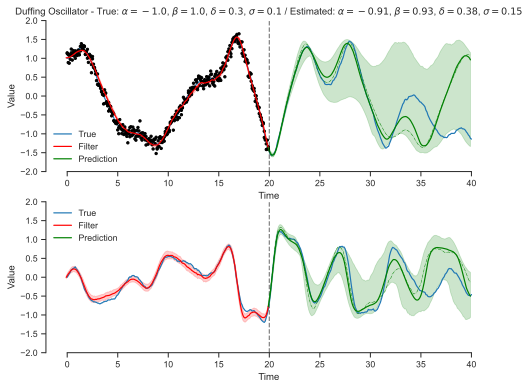

In [61]:
# Do filtering and smoothing
key, subkey = jr.split(key)
pas, log_L = filter.filter(ssm, us_train, ys_train, subkey)
key, subkey = jr.split(key)
lower, median, upper = pas.get_credible_interval(subkey)

key, subkey = jr.split(key)
pas_test = ssm.predict(pas[-1], us_test, subkey)

key, subkey = jr.split(key)
lower_test, median_test, upper_test = pas_test.get_credible_interval(subkey)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(ts, xs[:, 0], label='True')
ax[0].plot(ts_train, ys_train, 'k.')

ax[0].plot(ts_train_w_init, median[:, 0], 'r-', label='Filter')
ax[0].fill_between(ts_train_w_init, lower[:, 0], upper[:, 0], color='r', alpha=0.2)

ax[0].plot(ts_test, median_test[:, 0], 'g-', label='Prediction')
ax[0].fill_between(ts_test, lower_test[:, 0], upper_test[:, 0], color='g', alpha=0.2)
ax[0].plot(ts_test, pas_test.particles[:, 0::1000, 0], '-.', color='green', lw=0.5)

ax[0].set_ylim(-2, 2)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].legend(frameon=False, loc='best')

for a in ax:
    a.axvline(ts[200], linestyle='--', color='black', alpha=0.5)

ax[1].plot(ts, xs[:, 1], label='True')
ax[1].plot(ts_train_w_init, median[:, 1], 'r-', label='Filter')
ax[1].fill_between(ts_train_w_init, lower[:, 1], upper[:, 1], color='r', alpha=0.2)

ax[1].plot(ts_test, median_test[:, 1], 'g-', label='Prediction')
ax[1].fill_between(ts_test, lower_test[:, 1], upper_test[:, 1], color='g', alpha=0.2)
ax[1].plot(ts_test, pas_test.particles[:, 0::1000, 1], '-.', color='green', lw=0.5)

ax[1].set_ylim(-2, 2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].legend(frameon=False, loc='best')

ax[0].set_title(
    'Duffing Oscillator - True: $\\alpha=-1.0$, $\\beta=1.0$, $\\delta=0.3$, $\\sigma=0.1$ / Estimated: $\\alpha={:.2f}$, $\\beta={:.2f}$, $\\delta={:.2f}$, $\\sigma={:.2f}$'.format(
        ssm.transition.sde.alpha, ssm.transition.sde.beta, ssm.transition.sde.delta, ssm.likelihood.s))

sns.despine(trim=True)
plt.show()

The EM algorithm gives us a good way to find a point estimate of our parameters. We will use particle MCMC in the next notebook to get a full posterior distribution of the parameters.